In [1269]:
import numpy as np
import pandas as pd
import os
import warnings
from tqdm import tqdm
import math
import seaborn as sns

from scipy.stats import gamma
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import sys 
sys.path.append('..')
from utils.demand_pkg import *
import matplotlib.pyplot as plt
from utils.algorithms import get_opt, get_EQ, get_end2end_iid, get_end2end, get_normal_basestock, get_gamma_basestock, get_normal_basestock2

import tensorflow as tf

In [310]:
o0 = pd.read_csv('../data/1320_feature/features_v12.csv', parse_dates=['create_tm','complete_dt','dt'],
                 usecols=lambda col: col not in ['d_vlt'])

In [108]:
df_sales = pd.read_csv('../data/1320/rdc_sales_1320_replenishment_V1_filled_pp.csv')

In [1241]:
o0['IS_over_mean_56'] = (o0['initial_stock_overall'] / o0['mean_56']).replace(np.inf, 0).fillna(0)
o0['overall_opt_order_for_opt'] = o0['overall_opt_order'].copy()

In [1499]:
o1 = o0.copy()

In [1500]:
# o1.insert(1, 'sku_id', o1['item_sku_id'])
o1.loc[:,'sku_id'] = o1['item_sku_id'].apply(lambda x: x.split('#')[0])

In [1501]:
# o_num = o2.loc[:, feature_list+LABEL]
# for i in range(2, o_num.shape[1]):
#     plt.figure();
#     ax = sns.distplot(o_num.iloc[:,i]);
#     plt.savefig('../figures/vlm/%i.png' %i);
#     plt.close();

In [1502]:
sku_set = o1.sku_id.unique()
sku_train, sku_test = train_test_split(sku_set, random_state=10, train_size=0.9, test_size=0.1)

In [1542]:
IDX = ['item_sku_id','sku_id']

CAT_FEA = [
#     'item_first_cate_cd', 'item_second_cate_cd', 
    'item_third_cate_cd', 
    'int_org_num', 'brand_code', 
    'create_day_of_week'
    ]

VLT_FEA = [
    'uprc', 'contract_stk_prc', 
#     'wt', 'width', 'height', 'calc_volume', 'len',
#     'vlt_count', 'vlt_sum', 'vlt_min', 'vlt_max', 'vlt_mean', 'vlt_std',
    'qtty_sum', 'qtty_min', 'qtty_max', 'qtty_mean', 'qtty_std', 
#     'amount_sum', 'amount_min', 'amount_max', 'amount_mean', 'amount_std', 
    'vlt_count_6mo', 'vlt_sum_6mo', 'vlt_min_6mo', 'vlt_max_6mo', 'vlt_mean_6mo', 'vlt_std_6mo',
#     'vendor_vlt_count', 'vendor_vlt_sum', 'vendor_vlt_min', 'vendor_vlt_max', 'vendor_vlt_mean', 'vendor_vlt_std', 
#     'vendor_vlt_count_6mo', 'vendor_vlt_sum_6mo', 'vendor_vlt_min_6mo', 
#     'vendor_vlt_max_6mo', 'vendor_vlt_mean_6mo', 'vendor_vlt_std_6mo', 
#     'vendor_qtty_sum', 'vendor_qtty_min', 'vendor_qtty_max', 
#     'vendor_qtty_mean', 'vendor_qtty_std', 'vendor_amount_sum',
#     'vendor_amount_min', 'vendor_amount_max', 'vendor_amount_mean'
        ]

SF_FEA = [
#         'q_7', 'q_14', 'q_28', 'q_56', 'q_112', 
        'mean_3', 'mean_7', 'mean_14', 'mean_28', 'mean_56', 'mean_112', 
#         'diff_140_mean', 'mean_140_decay', 'median_140', 'min_140', 'max_140', 'std_140', 
#         'diff_60_mean', 'mean_60_decay', 'median_60', 'min_60', 'max_60', 'std_60', 
        'diff_30_mean', 'mean_30_decay', 'median_30', 'min_30', 'max_30', 'std_30', 
#         'diff_14_mean', 'mean_14_decay', 'median_14', 'min_14', 'max_14', 'std_14',
#         'diff_7_mean', 'mean_7_decay', 'median_7', 'min_7', 'max_7', 'std_7',
        'diff_3_mean', 'mean_3_decay', 'median_3', 'min_3', 'max_3', 'std_3',
#         'has_sales_days_in_last_140', 'last_has_sales_day_in_last_140',
#         'first_has_sales_day_in_last_140', 'has_sales_days_in_last_60',
#         'last_has_sales_day_in_last_60', 'first_has_sales_day_in_last_60',
#         'has_sales_days_in_last_30', 'last_has_sales_day_in_last_30',
#         'first_has_sales_day_in_last_30', 'has_sales_days_in_last_14',
#         'last_has_sales_day_in_last_14', 'first_has_sales_day_in_last_14',
#         'has_sales_days_in_last_7', 'last_has_sales_day_in_last_7', 'first_has_sales_day_in_last_7'
            ]
   
MORE_FEA =[
           'review_period', 
#            'normal', 
#            'gamma', 
            'eq'
            ]

IS_FEA = [
#            'initial_stock', 
#            'IS_over_mean_56'
        ]
    
# LABEL = ['target_decision']    
LABEL = ['demand_RV']    

feature_list =  VLT_FEA + SF_FEA + MORE_FEA + IS_FEA

# o0[VLT_CAT_FEA_COLS] = o0[VLT_CAT_FEA_COLS].astype('category')

# o1 = o0[VLT_CAT_FEA_COLS + VLT_NUM_FEA_COLS]

# o1 = pd.concat([df_vlt_fea, pd.get_dummies(df_vlt_fea[VLT_CAT_FEA_COLS])], axis=1)
# o2.drop(VLT_CAT_FEA_COLS, axis=1, inplace=True)

In [1543]:
low_qtl = o1[feature_list+LABEL].quantile(0.01)
hgh_qtl = o1[feature_list+LABEL].quantile(0.98)
o2 = o1.copy()
o2.loc[:, feature_list+LABEL] = o1[feature_list+LABEL].clip(low_qtl, hgh_qtl, axis=1)

In [1544]:
df_train = o2[o2['sku_id'].isin(sku_train)]
df_test = o2[o2['sku_id'].isin(sku_test)]

X_train_ns, y_train_ns, id_train = df_train[feature_list], df_train[LABEL], df_train[IDX]
X_test_ns, y_test_ns, id_test = df_test[feature_list], df_test[LABEL], df_test[IDX]

n_train, n_test = len(X_train_ns), len(X_test_ns)

In [1545]:
print(X_train_ns.mean_7.mean(), X_test_ns.mean_7.mean())

23.727653192383485 26.426782206006173


In [1546]:
X_scaler = MinMaxScaler() # For normalizing dataset
y_scaler = MinMaxScaler() # For normalizing dataset
# We want to predict Close value of stock 
X_train = pd.DataFrame(X_scaler.fit_transform(X_train_ns), columns=X_train_ns.columns)
y_train = pd.DataFrame(y_scaler.fit_transform(y_train_ns), columns=y_train_ns.columns)

X_test = pd.DataFrame(X_scaler.transform(X_test_ns), columns=X_test_ns.columns)
y_test = pd.DataFrame(y_scaler.transform(y_test_ns), columns=y_test_ns.columns)
# pd.DataFrame(min_max_scaler.inverse_transform(y_test), columns=y_test.columns)

In [1547]:
# mean = X_train_ns.mean(axis=0)
# std = X_train_ns.std(axis=0)
# X_train = (X_train_ns - mean) / std
# X_test = (X_test_ns - mean) / std

In [1548]:
vlt_dim = len(VLT_FEA)
sf_dim = len(SF_FEA)
oth_dim = len(MORE_FEA)
is_dim = len(IS_FEA)
input_dim = vlt_dim + sf_dim + oth_dim + is_dim

hidden_dim = [[120,150], [80,90], 100, 10]

output_dim = 1
q = 0.8


tf.reset_default_graph()
tf.set_random_seed(0)

with tf.name_scope('Data'):
    x_vlt = tf.placeholder(tf.float32, shape=[None, vlt_dim], name='Input_vlt')
    x_sf = tf.placeholder(tf.float32, shape=[None, sf_dim], name='Input_sf')
    x_oth = tf.placeholder(tf.float32, shape=[None, oth_dim], name='Input_more')
    x_is = tf.placeholder(tf.float32, shape=[None, is_dim], name='Input_IS')
    
with tf.name_scope('Label'):
    y = tf.placeholder(tf.float32, shape=[None, 1], name='Label')


with tf.variable_scope('Layer_1_vlt'):
    W1_vlt = tf.Variable(tf.truncated_normal([vlt_dim, hidden_dim[0][0]], stddev=0.001), name='Weight_1_vlt')
    b1_vlt = tf.Variable(tf.zeros([hidden_dim[0][0]]), name='Bias_1_vlt')
    l1_vlt = tf.add(tf.matmul(x_vlt, W1_vlt), b1_vlt)
    l1_vlt = tf.nn.relu(l1_vlt)

with tf.variable_scope('Layer_1_sf'):
    W1_sf = tf.Variable(tf.truncated_normal([sf_dim, hidden_dim[0][1]], stddev=0.001), name='Weight_1_sf')
    b1_sf = tf.Variable(tf.zeros([hidden_dim[0][1]]), name='Weight_1_sf')
    l1_sf = tf.add(tf.matmul(x_sf, W1_sf), b1_sf)
    l1_sf = tf.nn.relu(l1_sf)

with tf.variable_scope('Layer_2_vlt'):
    W2_vlt = tf.Variable(tf.truncated_normal([hidden_dim[0][0], hidden_dim[1][0]], stddev=0.001), name='Weight_2_vlt')
    b2_vlt = tf.Variable(tf.zeros([hidden_dim[1][0]]), name='Bias_2_vlt')
    l2_vlt = tf.add(tf.matmul(l1_vlt, W2_vlt), b2_vlt)
    l2_vlt = tf.nn.relu(l2_vlt)

with tf.variable_scope('Layer_2_sf'):
    W2_sf = tf.Variable(tf.truncated_normal([hidden_dim[0][1], hidden_dim[1][1]], stddev=0.001), name='Weight_2_sf')
    b2_sf = tf.Variable(tf.zeros([hidden_dim[1][1]]), name='Bias_2_sf')
    l2_sf = tf.add(tf.matmul(l1_sf, W2_sf), b2_sf)
    l2_sf = tf.nn.relu(l2_sf)


with tf.variable_scope('Layer_3'):
    W3 = tf.Variable(tf.truncated_normal([hidden_dim[1][0]+hidden_dim[1][1], hidden_dim[2]], stddev=0.001), name='Weight_3')
    b3 = tf.Variable(tf.zeros([hidden_dim[2]]), name='Bias_3')
    l3 = tf.add(tf.matmul(tf.concat([l2_vlt, l2_sf], axis=1), W3), b3)
    l3 = tf.nn.relu(l3)

with tf.variable_scope('Layer_4'):
    W4 = tf.Variable(tf.truncated_normal([hidden_dim[2]+oth_dim, hidden_dim[3]], stddev=0.001), name='Weight_4')
    b4 = tf.Variable(tf.zeros([hidden_dim[3]]), name='Bias_4')
    l4 = tf.add(tf.matmul(tf.concat([l3, x_oth], axis=1), W4), b4)
    l4 = tf.nn.relu(l4)

with tf.variable_scope('Layer_final'):
    W5 = tf.Variable(tf.truncated_normal([hidden_dim[3]+is_dim,1], stddev=0.001), name='Weight_5')
    b5 = tf.Variable(tf.zeros([1]), name='Bias_5')
    output = tf.add(tf.matmul(tf.concat([l4, x_is], axis=1), W5), b5)
    error = y - output
    loss = tf.reduce_mean(tf.square(tf.maximum(q*error, (q-1)*error)) )

with tf.name_scope('Optimizer'):
    train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)


In [1549]:
vlt_dim = len(VLT_FEA)
sf_dim = len(SF_FEA)
oth_dim = len(MORE_FEA)
is_dim = len(IS_FEA)
input_dim = vlt_dim + sf_dim + oth_dim + is_dim

hidden_dim = [[20,25], 30, 10]

output_dim = 1
q = 0.9


tf.reset_default_graph()
tf.set_random_seed(0)

with tf.name_scope('Data'):
    x_vlt = tf.placeholder(tf.float32, shape=[None, vlt_dim], name='Input_vlt')
    x_sf = tf.placeholder(tf.float32, shape=[None, sf_dim], name='Input_sf')
    x_oth = tf.placeholder(tf.float32, shape=[None, oth_dim], name='Input_more')
    x_is = tf.placeholder(tf.float32, shape=[None, is_dim], name='Input_IS')

with tf.name_scope('Label'):
    y = tf.placeholder(tf.float32, shape=[None, 1], name='Label')


with tf.variable_scope('Layer_1_vlt'):
    W1_vlt = tf.Variable(tf.truncated_normal([vlt_dim, hidden_dim[0][0]], stddev=0.001), name='Weight_1_vlt')
    b1_vlt = tf.Variable(tf.zeros([hidden_dim[0][0]]), name='Bias_1_vlt')
    l1_vlt = tf.add(tf.matmul(x_vlt, W1_vlt), b1_vlt)
    l1_vlt = tf.nn.relu(l1_vlt)

with tf.variable_scope('Layer_1_sf'):
    W1_sf = tf.Variable(tf.truncated_normal([sf_dim, hidden_dim[0][1]], stddev=0.001), name='Weight_1_sf')
    b1_sf = tf.Variable(tf.zeros([hidden_dim[0][1]]), name='Weight_1_sf')
    l1_sf = tf.add(tf.matmul(x_sf, W1_sf), b1_sf)
    l1_sf = tf.nn.relu(l1_sf)

with tf.variable_scope('Layer_2'):
    W2 = tf.Variable(tf.truncated_normal([hidden_dim[0][0]+hidden_dim[0][1], hidden_dim[1]], stddev=0.001), name='Weight_2')
    b2 = tf.Variable(tf.zeros([hidden_dim[1]]), name='Bias_3')
    l2 = tf.add(tf.matmul(tf.concat([l1_vlt, l1_sf], axis=1), W2), b2)
    l2 = tf.nn.relu(l2)

with tf.variable_scope('Layer_3'):
    W3 = tf.Variable(tf.truncated_normal([hidden_dim[1]+oth_dim, hidden_dim[2]], stddev=0.001), name='Weight_3')
    b3 = tf.Variable(tf.zeros([hidden_dim[2]]), name='Bias_3')
    l3 = tf.add(tf.matmul(tf.concat([l2, x_oth], axis=1), W3), b3)
    l3 = tf.nn.relu(l3)

with tf.variable_scope('Layer_final'):
    W4 = tf.Variable(tf.truncated_normal([hidden_dim[2]+is_dim, 1], stddev=0.001), name='Weight_4')
    b4 = tf.Variable(tf.zeros([1]), name='Bias_4')
    output = tf.add(tf.matmul(tf.concat([l3, x_is], axis=1), W4), b4)
    error = y - output
#     loss = tf.reduce_mean(tf.square(tf.maximum(q*error, (q-1)*error)) )
    loss = tf.reduce_mean(tf.maximum(q*error, (q-1)*error)) 

with tf.name_scope('Optimizer'):
    train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)


In [1550]:
epochs = 20
batch_size = 64
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
writer = tf.summary.FileWriter("output", sess.graph)
writer.close()


train_err = sess.run(loss, feed_dict={x_vlt: X_train[VLT_FEA].values, 
                                     x_sf: X_train[SF_FEA].values, 
                                     x_oth: X_train[MORE_FEA].values, 
                                     x_is: X_train[IS_FEA].values, 
                                     y: y_train.values})
test_err = sess.run(loss, feed_dict={x_vlt: X_test[VLT_FEA].values, 
                                     x_sf: X_test[SF_FEA].values, 
                                     x_oth: X_test[MORE_FEA].values, 
                                     x_is: X_test[IS_FEA].values, 
                                     y: y_test.values})
print(0, train_err, test_err)
for epoch in range(epochs):
    # Split data to batches
    train_err = 0
    for idx in range(0, X_train.shape[0], batch_size):
        bs = min(idx + batch_size, n_train) - idx
        batch_data = X_train.iloc[idx:bs+idx, :]
        batch_labels = y_train.iloc[idx:bs+idx, :]
        feed_dict = {x_vlt: batch_data[VLT_FEA].values, 
                     x_sf: batch_data[SF_FEA].values, 
                     x_oth: batch_data[MORE_FEA].values,
                     x_is: batch_data[IS_FEA].values,
                     y: batch_labels}
        _, c_loss = sess.run([train_step, loss], feed_dict)
        train_err += c_loss*bs
    test_err = sess.run(loss, feed_dict={x_vlt: X_test[VLT_FEA].values, 
                                         x_sf: X_test[SF_FEA].values, 
                                         x_oth: X_test[MORE_FEA].values, 
                                         x_is: X_test[IS_FEA].values, 
                                         y: y_test.values})
    print(epoch+1, train_err/n_train, test_err)

0 0.07878416 0.08850315
1 0.029790779091955433 0.011198963
2 0.00841697254420661 0.009633002
3 0.007769136542699547 0.009275843
4 0.007427974010437508 0.009015575
5 0.007172766021439258 0.00881052
6 0.0069852250117741965 0.008645343
7 0.006861195420897713 0.008530695
8 0.006775874988297653 0.008468023
9 0.006722557885586085 0.008406206
10 0.0066884854896375094 0.008366337
11 0.006670927547364671 0.008348887
12 0.006652963324273406 0.008332541
13 0.006637130667315548 0.008315488
14 0.006621621988209906 0.008309952
15 0.006610749723687521 0.008296965
16 0.006595094557630133 0.008279833
17 0.006584827967941479 0.008274673
18 0.006570064540843068 0.008270996
19 0.00655509153856015 0.008258591
20 0.00654246189109007 0.008251267


In [1551]:
pred = sess.run(output, feed_dict={x_vlt: X_test[VLT_FEA].values, 
                                  x_sf: X_test[SF_FEA].values, 
                                  x_oth: X_test[MORE_FEA].values, 
                                  x_is: X_test[IS_FEA].values, 
                                  })

pred = pd.DataFrame(y_scaler.inverse_transform(pred), columns=['prediction']).fillna(0)

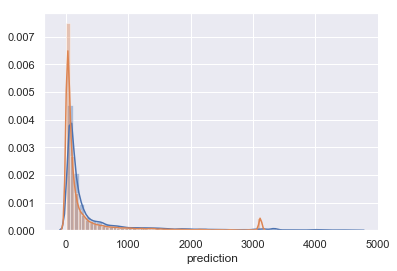

In [1552]:
sns.distplot(pred['prediction']);
sns.distplot(y_test_ns);

In [1553]:

def get_opt(df_opt, inv, t, sku_dc):
    opt = df_opt.iloc[t]['overall_opt_order_for_opt']
    #opt = df['overall_opt_order'].iloc[t] 
#     opt = df['overall_opt_order'].iloc[t] 
    return opt

def get_EQ(record, inv, t, renew_period, PERCENT=90):
    sales = record[0:t]
    EQ_series = [np.sum(sales[i:i+renew_period]) for i in range(len(sales)-renew_period)]
    EQ_value = np.percentile(EQ_series, PERCENT)
    action = np.max([EQ_value - inv, 0])
    return int(action)

def get_gamma_basestock(record, inv, t, renew_period, PERCENT=0.9):
    sales = record[0:t]
    mean = np.mean(sales)
    var = np.var(sales)
    theta = var/(mean+0.0000001)
    k = mean/(theta+0.0000001)
    k_sum = renew_period*k
    gamma_stock = gamma.ppf(PERCENT, a=k_sum, scale = theta)
    if(np.isnan(gamma_stock)):
        return 0
    else:
        action = np.max([int(gamma_stock)-inv, 0])
    return action
    
    
def get_end2end(gbm, df, inv, feature_list):

    xx = df.copy()
    xx['initial_stock'] = inv
    xx['IS_over_mean_56'] = (inv/xx['mean_56']).replace(np.inf, 0).fillna(0).clip(0, 100)
    xx = xx.loc[:, feature_list] 
    test_x = pd.DataFrame(X_scaler.transform(xx.loc[:, feature_list]), columns=xx.columns)
    pp = sess.run(output, feed_dict={x_vlt: test_x[VLT_FEA].values, 
                                       x_sf: test_x[SF_FEA].values, 
                                       x_oth: test_x[MORE_FEA].values, 
                                       x_is: test_x[IS_FEA].values, 
                                       })
    pred = y_scaler.inverse_transform(pp)[0][0]

    action = min(max(pred-inv, 0), 2000)
    return int(action)


def get_normal_basestock(inv, sales_mean, sales_std, renew_period, VLT_mean, VLT_std, Z90 = 1.2816):
    VLT_std = 0
    action = np.max([0, sales_mean*(renew_period+VLT_mean)+
                     Z90*np.sqrt((renew_period+VLT_mean)*sales_std**2
                                 +sales_std**2*VLT_std)-inv])
    return int(action)

def get_normal_basestock2(record, inv, t, renew_period, VLT_mean, VLT_std, Z90 = 1.2816):
    sales = record[0:t]
    sales_mean = np.mean(sales)
    sales_std = np.std(sales)
    VLT_std = 0
    action = np.max([0, sales_mean*(renew_period+VLT_mean)+
                     Z90*np.sqrt((renew_period+VLT_mean)*sales_std**2
                                 +sales_std**2*VLT_std)-inv])
    return int(action)


In [1554]:
def countOccurrences(arr, x):
    res = 0
    for i in range(len(arr)):
        if x == arr[i]:
            res += 1
    return res


def num_neg_element(data_list):
    counter = 0
    for i in data_list:
        if i <= 0:
            counter+=1
    return counter


def seqtest(sku_dc, START_DAY, inv0, df, gbm_dq, end_of_horizon, arrive_time, order_time, demand, feature_list):
    inv = [inv0]*6
    h = 1
    b = 9
    history_inv = [ [],[],[],[],[],[] ]
    order_list = [ [],[],[],[],[],[] ]
    h_cost_list = [ [],[],[],[],[],[] ]
    b_cost_list = [ [],[],[],[],[],[] ]
    cost_list = [ [],[],[],[],[],[] ]
    #print('Initial Inventory:', inv0)
    for t in range(order_time[0], end_of_horizon):
#     for t in range(end_of_horizon):

        if t in order_time:
            occurance = countOccurrences(order_time, t)
            count = occurance
            while(occurance>0):
                i = order_time.index(t)+ count - occurance
                cur_state = df.iloc[i:i+1,:]
                #renew_period = cur_state['review_period']
                renew_period = cur_state['review_period']
                if(i<len(order_time)-1):
                    renew_period = order_time[i+1]-order_time[i]
                else:
                    renew_period = np.max([end_of_horizon-1-order_time[i]-int(cur_state['vendor_vlt_mean']), 0])
                '''---------------------- OPTION 0: optimal DP ---------------------------------------'''
                '''---------------------- OPTION 1: Emperical Quantile -------------------------------'''
                '''---------------------- OPTION 2: End2end DP ---------------------------------------'''
                '''---------------------- OPTION 3: Normal Basestock ---------------------------------'''
                '''---------------------- OPTION 4: Gamma Basestock ----------------------------------'''
                '''---------------------- OPTION 5: Historical ---------------------------------------'''
                order = [0] * 6
                order[0] = get_opt(df, inv[0], i, sku_dc)
                order[1] = get_EQ(demand, inv[1], t+START_DAY, renew_period+int(cur_state['vendor_vlt_mean']), PERCENT=90)   
                order[2] = get_end2end(gbm_dq, cur_state, inv[2], feature_list)
                order[3] = get_normal_basestock2(demand, inv[3], t+START_DAY, renew_period, cur_state['vendor_vlt_mean'], cur_state['vendor_vlt_std'], Z90 = 1.2816)
                order[4] = get_gamma_basestock(demand, inv[4], t+START_DAY, renew_period+int(cur_state['vendor_vlt_mean']), PERCENT=0.9)
                order[5] = cur_state['actual_pur_qtty'].values[0]
                for bm in range(6):
                    order_list[bm].append(order[bm])
                occurance = occurance-1
        
        if t in arrive_time:
            occurance = countOccurrences(arrive_time, t)
            while(occurance>0):
                i = arrive_time.index(t)+occurance-1
                for bm in range(6):
                    if bm == 5 and inv[bm] < 0:
                        inv[5] = 0
                    inv[bm] = inv[bm] + order_list[bm][i]
                occurance = occurance-1


        for bm in range(6):
            inv[bm] = inv[bm] - demand[START_DAY+t]
            h_cost = h*np.maximum(0, inv[bm])
            b_cost = b*np.maximum(0, -inv[bm])
            h_cost_list[bm].append(h_cost)
            b_cost_list[bm].append(b_cost)
            cost_list[bm].append(h_cost+b_cost)
            history_inv[bm].append(int(inv[bm]))
            
    return history_inv, [sum(cost_list[bm]) for bm in range(6)], [sum(b_cost_list[bm]) for bm in range(6)], [sum(h_cost_list[bm]) for bm in range(6)]
                        

In [1555]:
gbm_dq = 'useless'
test_pair = id_test['item_sku_id'].unique()
numberOfRows = len(test_pair)

list_c = ['SKU_DC', 'OPT', 'End2End', 'EQ',  'Normal', 'Gamma', 'Hist', 
          'Ave_sales','Std_sales', 
#           'Ave_review', 'Std_review'
         ]
df_cost = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_holding = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_back = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_stockout = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_turnover = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)

# t = TEST_INDEX
START_DAY_HIST = 731 # if test 2018, set this to 731; if 2017: 366
START_DAY = 181 #2018/07/01
end_of_horizon =  62 #2017/07/01-2017/09/15:77 (if 2018/07/01-2018/08/20: 51)


for i in range(len(test_pair)):
# for i in (range(10)):
    if i % 100 == 0:
        print(i, end=', ')
        
    sku_dc = test_pair[i]
#     sku = 5808933, dc = 3
#     print(sku_dc)
    df_cost.loc[i]['SKU_DC'] = sku_dc
    df_holding.loc[i]['SKU_DC'] = sku_dc
    df_back.loc[i]['SKU_DC'] = sku_dc
    df_stockout.loc[i]['SKU_DC'] = sku_dc
    df_turnover.loc[i]['SKU_DC'] = sku_dc
    
#     #############get parameter for specific pair of sku, dc
    df = df_test.loc[df_test.item_sku_id == sku_dc,:]

    ref_time = START_DAY_HIST+START_DAY
    order_time = df['create_tm_index'].tolist()
    order_time = [time-ref_time for time in order_time] 
    arrive_time = df['complete_dt_index'].tolist()
    arrive_time = [time-ref_time for time in arrive_time]

    demand = df_sales[df_sales.row == sku_dc].values[0]
#     stk = df_stocks[(df_stocks.sku_id == sku) & (df_stocks.int_org_num == dc)].values[0]

    if(len(demand)==0):
        t = t+1
    else:
#         demand = np.delete(demand, 0) #? 
        demand = demand[START_DAY_HIST + 1:] 
#         review_periods = df['review_period'].values

#         if (sku, dc) not in good_pair:
#             t = t + len(feature)
#             continue
        
#         stk = stk[START_DAY_HIST + START_DAY + 2:] 
#         inv0 = stk[0]
        inv0 = np.array(df['initial_stock'])[0]

        h = 1
        b = 9
        
        inv, c, b, h = seqtest(sku_dc, START_DAY, inv0, df, gbm_dq, end_of_horizon, arrive_time, order_time, demand, feature_list)

        
        sales_mean = np.mean(demand[START_DAY:START_DAY+end_of_horizon])
        Ave_sales = np.mean(demand)
        Std_sales = np.std(demand)
#         Ave_review = np.mean(review_periods[:-1])
#         Std_review = np.std(review_periods[:-1])
        
        df_cost.iloc[i,1:] = [c[0], c[2], c[1], c[3], c[4], c[5], Ave_sales, Std_sales, 
#                               Ave_review, Std_review
                             ]
        df_holding.iloc[i,1:] = [h[0], h[2], h[1], h[3], h[4], h[5], Ave_sales, Std_sales, 
#                                  Ave_review, Std_review
                                ]
        df_back.iloc[i,1:] = [b[0], b[2], b[1], b[3], b[4], b[5], Ave_sales, Std_sales, 
#                               Ave_review, Std_review
                             ]
        df_stockout.iloc[i,1:] = [num_neg_element(inv[0])/len(inv[0]), 
                                   num_neg_element(inv[2])/len(inv[2]), 
                                   num_neg_element(inv[1])/len(inv[1]), 
                                   num_neg_element(inv[3])/len(inv[3]), 
                                   num_neg_element(inv[4])/len(inv[4]), 
                                   num_neg_element(inv[5])/len(inv[5]), 
                                   Ave_sales, Std_sales, 
#                                   Ave_review, Std_review
                                 ]
        df_turnover.iloc[i,1:] = [np.mean(inv[0])/sales_mean,
                                   np.mean(inv[2])/sales_mean,
                                   np.mean(inv[1])/sales_mean,
                                   np.mean(inv[3])/sales_mean,
                                   np.mean(inv[4])/sales_mean,
                                   np.mean(inv[5])/sales_mean,
                                   Ave_sales, Std_sales, 
#                                    Ave_review, Std_review
                                 ]

#         t = t + len(feature)
        
#     fig, ax1 = plt.subplots(figsize=(8, 6))
#     ax1.plot(inv1, label = 'DP optimal')
#     ax1.plot(inv3, label = 'End2end')
#     ax1.plot(inv2, label = 'Emperical Quantile')
#     ax1.plot(inv4, label = 'Normal Basestock')
#     ax1.plot(inv5, label = 'Gamma Basestock')
#     ax1.plot(inv6, label = 'Historical Decision')
#     ax1.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
#     ax1.grid()
#         plt.show()
#     plt.savefig('fig/%i_%i.png' %(sku,dc), dpi=150)

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 

In [1556]:
df_cost.dropna(how='any', inplace=True)
df_holding.dropna(how='any', inplace=True)
df_back.dropna(how='any', inplace=True)
df_stockout.dropna(how='any', inplace=True)
df_turnover.dropna(how='any', inplace=True)
df_turnover = df_turnover[~df_turnover.isin([np.inf, -np.inf]).any(1)]
len(df_cost), len(df_holding), len(df_back), len(df_stockout), len(df_turnover)

(3258, 3258, 3258, 3258, 3254)

In [1557]:
win_eq = 0
win_dp = 0
win_iid = 0
win_normal = 0
win_gamma = 0
win_hist = 0
cost_opt = []
cost_eq = []
cost_dp = []
#cost_iid = []
cost_normal = []
cost_gamma = []
cost_hist = []
TIMER = 0
# df = df_cost[df_cost['Ave_sales']>1]
df = df_cost

index_dp = []
index_eq = []
index_normal = []
index_gamma = []
index_hist = []
for i in range(len(df)):
    if((not math.isnan(df.iloc[i]['EQ'])) and (not math.isinf(df.iloc[i]['EQ']))):
        TIMER +=1
        bill = np.array([df.iloc[i]['EQ'],df.iloc[i]['End2End'],df.iloc[i]['Normal'], df.iloc[i]['Gamma'], df.iloc[i]['Hist']])
        index_min = np.argmin(bill)
        if(index_min == 0):
            win_eq +=1
            index_eq.append(i)
        elif(index_min == 1):
            win_dp+=1
            index_dp.append(i)
        elif(index_min == 2):
            win_normal+=1
            index_normal.append(i)
        elif(index_min == 3):
            win_gamma +=1
            index_gamma.append(i)
        elif(index_min == 4):
            win_hist+=1
            index_hist.append(i)
        else:
            pass
        
        if(df.iloc[i]['OPT']>=0):
            cost_opt.append(df.iloc[i]['OPT'])
        if(df.iloc[i]['EQ']>=0):
            cost_eq.append(df.iloc[i]['EQ'])
        if(df.iloc[i]['End2End']>=0):
            cost_dp.append(df.iloc[i]['End2End'])
        #cost_iid.append(df_cost.iloc[i]['End2End_iid'])
        if(df.iloc[i]['Normal']>=0):
            cost_normal.append(df.iloc[i]['Normal'])
        if(df.iloc[i]['Gamma']>=0):
            cost_gamma.append(df.iloc[i]['Gamma'])
        if(df.iloc[i]['Hist']>=0):
            cost_hist.append(df.iloc[i]['Hist'])

#cost_eq = np.sort(cost_eq)
#cost_dp = np.sort(cost_dp)
#cost_iid = np.sort(cost_iid)
#cost_normal = np.sort(cost_normal)
#cost_gamma = np.sort(cost_gamma)

print('End2End DP Win:', win_dp/TIMER, 
      'EQ Win:', win_eq/TIMER,   
      'Normal Basestock Win:', win_normal/TIMER, 
      'Gamma Basestock Win:', win_gamma/TIMER, 
      'Historical win:', win_hist/TIMER)  
print('Average order cost', 'OPT:', np.mean(cost_opt), 
      'End2End DP:', np.mean(cost_dp), 
      'EQ:', np.mean(cost_eq), 
      'Normal Basestock:', np.mean(cost_normal), 
      'Gamma:', np.mean(cost_gamma),
      'Historical Decision:', np.mean(cost_hist))

End2End DP Win: 0.07888275015346839 EQ Win: 0.1240024554941682 Normal Basestock Win: 0.12737875997544507 Gamma Basestock Win: 0.1445672191528545 Historical win: 0.5251688152240639
Average order cost OPT: 5349.250767341928 End2End DP: 27565.07182320442 EQ: 23640.528852056475 Normal Basestock: 17419.738182934314 Gamma: 17211.082565991404 Historical Decision: 13116.312154696132


In [1558]:
pd.DataFrame({'Total': df_cost[['OPT','End2End','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Holding': df_holding[['OPT','End2End','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Back': df_back[['OPT','End2End','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Stockout': df_stockout[['OPT','End2End','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Turnover': df_turnover[['OPT','End2End','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             }).T

,OPT,End2End,EQ,Normal,Gamma,Hist,Ave_sales
Total,5349.250767,27565.071823,23640.528852,17419.738183,17211.082566,13116.312155,16.672058
Holding,4100.035298,9942.671271,21050.244322,13971.332106,13607.538367,8635.671271,16.672058
Back,1249.215470,17622.400552,2590.284530,3448.406077,3603.544199,4480.640884,16.672058
Stockout,0.246624,0.107424,0.126553,0.143123,0.145853,0.180402,16.672058
Turnover,8.100949,54.554785,49.789896,36.157419,35.821669,24.237117,16.692318


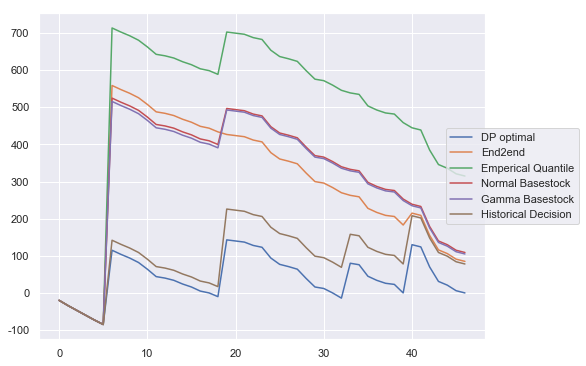

In [1561]:
# sku_dc = test_pair[302]
sku_dc = '258236#3'
#     #############get parameter for specific pair of sku, dc
df = df_test[df_test.item_sku_id == sku_dc]

ref_time = START_DAY_HIST+START_DAY
order_time = df['create_tm_index'].tolist()
order_time = [time-ref_time for time in order_time] 
arrive_time = df['complete_dt_index'].tolist()
arrive_time = [time-ref_time for time in arrive_time]

demand = df_sales[df_sales.row == sku_dc].values[0]
#     stk = df_stocks[(df_stocks.sku_id == sku) & (df_stocks.int_org_num == dc)].values[0]

if(len(demand)==0):
    t = t+1
else:
    demand = demand[START_DAY_HIST + 1:] 

    inv0 = np.array(df['initial_stock'])[0]

    h = 1
    b = 9

    inv, c, b, h = seqtest(sku_dc, START_DAY, inv0, df, gbm_dq, end_of_horizon, arrive_time, order_time, demand, feature_list)

    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax1.plot(inv[0], label = 'DP optimal')
    ax1.plot(inv[2], label = 'End2end')
    ax1.plot(inv[1], label = 'Emperical Quantile')
    ax1.plot(inv[3], label = 'Normal Basestock')
    ax1.plot(inv[4], label = 'Gamma Basestock')
    ax1.plot(inv[5], label = 'Historical Decision')
    ax1.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))

In [1560]:
tt = X_test.iloc[2:3,:].loc[:,feature_list]
tt['IS_over_mean_56'] = 0.1
# print(tt.values)
pp = sess.run(output, feed_dict={x_vlt: tt[VLT_FEA].values, 
                            x_sf: tt[SF_FEA].values, 
                            x_oth: tt[MORE_FEA].values, 
                            x_is: tt[IS_FEA].values, 
                            })
pd.DataFrame(y_scaler.inverse_transform(pp), columns=['prediction'])

,prediction
0,457.533325


In [ ]:
sess.close()